# Visualsing Active Selections via PCA

In [34]:
# remove after testing
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of mclearn.heuristics failed: Traceback (most recent call last):
  File "D:\Projects\Python\Anaconda3\lib\site-packages\IPython\extensions\autoreload.py", line 247, in check
    superreload(m, reload, self.old_objects)
NameError: name 'kwargs' is not defined
]


In [35]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.cross_validation import KFold, ShuffleSplit, StratifiedShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from mclearn.active import ActiveLearner
from mclearn.classifier import grid_search_logistic
from mclearn.heuristics import (random_h, margin_h, entropy_h,
                                qbb_margin_h, qbb_kl_h,
                                pool_entropy_h, pool_variance_h)
from mclearn.preprocessing import balanced_train_test_split
from mclearn.tools import results_exist, load_results
%matplotlib inline
plt.style.use('ggplot')

In [3]:
vstatlas = pd.read_hdf('../data/vstatlas.h5', 'vstatlas')
fig_dir = '../thesis/figures/'
target_col = 'class'
feature_cols = ['rmagC', 'umg', 'gmr', 'rmi', 'imz', 'rmw1', 'w1m2']

In [4]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(vstatlas[feature_cols])
y = np.array(vstatlas[target_col])

In [5]:
# These are the "Tableau 20" colors as RGB.
tableau10 = [(214, 39, 40), (31, 119, 180), (44, 160, 44),
             (255, 127, 14), (148, 103, 189), (140, 86, 75),
             (127, 127, 127), (23, 190, 207), (188, 189, 34), (227, 119, 194)]

# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.
for i in range(len(tableau10)):
    r, g, b = tableau10[i]
    tableau10[i] = (r / 255., g / 255., b / 255.)

In [6]:
def plot_scatter_with_classes(data, targets, classes, size=10, alpha=0.1,
    scatterpoints=1000, ax=None):
    
    if not ax:
        ax = plt.gca()

    class_data = {}
    cls_scatters = []
    for i, cls in enumerate(classes):
        class_data[cls] = data[targets == cls]
        cls_scatter = ax.scatter(class_data[cls][:,0], class_data[cls][:,1], s=size,
            alpha=alpha, c=tableau10[i], label=cls)
        cls_scatters.append(cls_scatter)

    ax.legend(cls_scatters, classes, scatterpoints=scatterpoints, loc='upper right',
        frameon=True, ncol=1)
    ax.grid(False)

    return ax

In [56]:
print(plt.style.available)

['dark_background', 'fivethirtyeight', 'bmh', 'ggplot', 'grayscale']


In [7]:
pca = PCA(n_components=2)
projection = pca.fit_transform(X_scaled)
classes = ['Star', 'Galaxy', 'Quasar', 'White Dwarf']


(-5, 5)

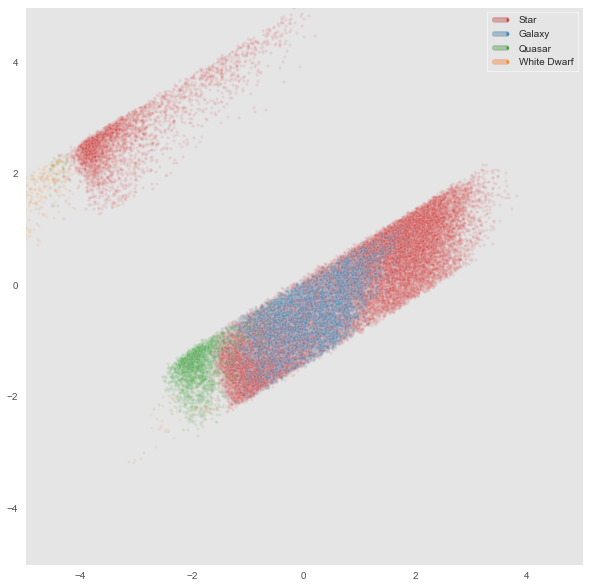

In [9]:
fig = plt.figure(figsize=(10, 10))
ax = plot_scatter_with_classes(projection, y, classes)
ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
#fig.savefig(fig_dir + 'pca_scatter.png', bbox_inches='tight', dpi=300)

In [10]:
lc, sel = load_results('../pickle/07_vstatlas/active_margin.pickle')

In [14]:
scaler = StandardScaler()
transformer = PolynomialFeatures(degree=2, interaction_only=False, include_bias=True)

X_scaled = scaler.fit_transform(vstatlas[feature_cols])
X_poly = transformer.fit_transform(X_scaled)
y = np.array(vstatlas[target_col])

# balance the training set
X_poly, _, y, _ = balanced_train_test_split(X_poly, y, train_size=2360, test_size=0, random_state=11)

kfold = StratifiedShuffleSplit(y, n_iter=10, test_size=0.3, train_size=0.7,
                               random_state=19)

In [27]:
pca = PCA(n_components=2)
projection = pca.fit_transform(X_scaled)

In [28]:
for i, (train_index, test_index) in enumerate(kfold):
        X_train = X_scaled[train_index]
        X_test = X_scaled[test_index]
        y_train = y[train_index]
        y_test = y[test_index]
        break

In [29]:
X_train_2 = pca.transform(X_train)

In [32]:
def plot_scatter_with_classes_2(data, targets, classes, size=20, alpha=0.5,
    scatterpoints=10, ax=None):
    
    if not ax:
        ax = plt.gca()

    class_data = {}
    cls_scatters = []
    for i, cls in enumerate(classes):
        class_data[cls] = data[targets == cls]
        cls_scatter = ax.scatter(class_data[cls][:,0], class_data[cls][:,1], s=size,
            alpha=alpha, c=tableau10[i], label=cls)
        cls_scatters.append(cls_scatter)

    ax.legend(cls_scatters, classes, scatterpoints=scatterpoints, loc='upper right',
        frameon=True, ncol=1)
    ax.grid(False)

    return ax

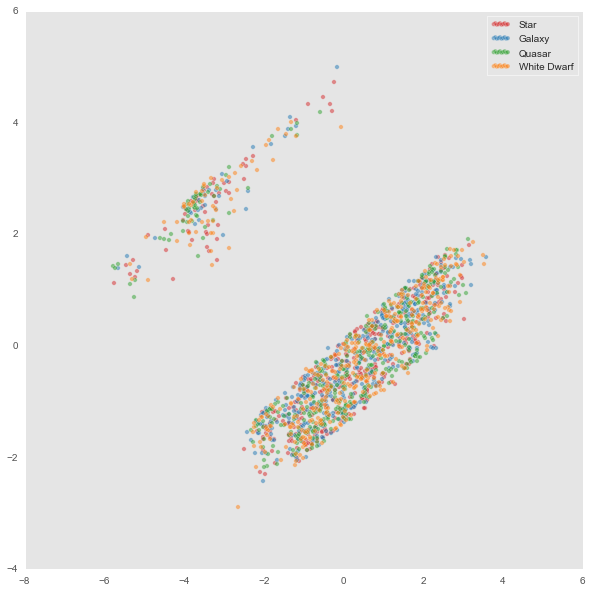

In [33]:
classes = ['Star', 'Galaxy', 'Quasar', 'White Dwarf']
fig = plt.figure(figsize=(10, 10))
ax = plot_scatter_with_classes_2(X_train_2, y_train, classes)
#ax.set_xlim(-5, 5)
#ax.set_ylim(-5, 5)